# Data Processing Pipeline

# Notebook Overview and Usage Instructions

Brief note: I'll work on making things more modular

## Overview
I wrote this Jupyter Notebook as a way to process and integrate data from Discogs and Spotify to create a graph representation of artist collaborations. The notebook does the following things below:

1. **Extracting Nodes and Edges from Song Releases Given a discogs_release dataset**:
   - Parses XML files from the `data_raw` directory to extract artist collaborations.
   - Generates a list of edges (collaborations) and nodes (unique artists).
   - Make sure to download RELEASE datasets from discogs and put it into the folder to be parsed

2. **Spotify API Integration**:
   - Initializes the Spotify API
   - Fetches artist metadata such as genres, popularity, and follower count.

3. **Data Integration and Storage**:
   - Combines Discogs artist data with Spotify metadata.
   - Saves the processed data as Parquet files in the `data_processed` directory for efficient storage and retrieval.

4. **Example Graph Creation**:
   - Builds a graph using NetworkX to represent artist collaborations.
   - Nodes represent artists, and edges represent collaborations between them.

## Instructions

### Prerequisites
1. **Setup**:
   - Install dependencies using `pip install -r requirements.txt`
   - Please add to this file if more dependencies are needed

2. **Spotify API Credentials**:
    - Make sure to have `.env` file, I will send this to you guys

3. **Data Files**:
   - Place Discogs RELEASE XML files in the `data_raw` directory.

### Steps to Use
1. **Run the Notebook**:
   - Execute each cell sequentially to process the data.

2. **Verify Outputs**:
   - Check the `data_processed` directory for generated Parquet files.
   - Ensure the graph is created and visualized correctly.

3. **Modify Parameters**:
   - Adjust the number of artists processed by modifying the `unique_artists` slicing in the Spotify API integration section.
   - I'll work on integrating popularity as a filter parameter.


### Some other notes/gimmicks I included
- The notebook includes rate limiting to avoid exceeding Spotify API limits.
- Ensure the `data_raw` directory contains valid XML files for processing.
- Modify the paths in the notebook if the directory structure changes.
- I've also only tested on 2008 and 2010 datasets, the more recent ones are too large and I can't even open the zip file on my computer

## Extracting edges from song releases

Below is the code that extracts song releases from discogs release type files.

Strips troublesome control characters as well as adding a root element so iterparse can parse.

This only gets an edge if artists >= 2

Drag discogs files and change the path name as needed.

In [1]:
import xml.etree.ElementTree as ET
import io
import re
import pandas as pd
import os
import glob

edges = []
nodes = set()

# will get all xml files in the data_raw folder
xml_files = glob.glob("../data_raw/*.xml")

for file_path in xml_files:
    print(f"Processing {file_path}")
    with open(file_path, "r", encoding="utf-8") as file:
        raw = file.read()

    # stripping control characters and escaping stray ampersands
    raw = re.sub(r"[\x00-\x08\x0B\x0C\x0E-\x1F]", "", raw)
    safe = re.sub(r"&(?!(amp|lt|gt|apos|quot|#\d+);)", "&amp;", raw)

    # adding a root element because iterparse needs to find a root element to parse
    wrapped_source = "<root>\n" + safe + "\n</root>"

    for event, elem in ET.iterparse(io.StringIO(wrapped_source), events= ("end",)):
        # want to look by song release
        if elem.tag == "release":
            # for each song release we get the artists by the id and then name
            artists = [
                    a.findtext("id") or a.findtext("name") for a in elem.findall("./artists/artist")
            ]
            
            # removes all the nones (data is old so might be bad)
            artists = [a for a in artists if a]
            # generate nodes and edges for all pairs, we are only looking for artists collaborations
            if len(artists) >= 2:
                for i in range(len(artists)):
                    nodes.add(artists[i])
                    for j in range(i+1, len(artists)):
                        edges.append((artists[i], artists[j]))

            elem.clear()

Processing ../data_raw/discogs_20100201_releases.xml
Processing ../data_raw/discogs_20100101_releases.xml
Processing ../data_raw/discogs_20100101_releases.xml


In [2]:
#checking if the edge list is created correctly
for u, v in edges[:14]:
    print(f"{u} <-> {v}")

DJ Romain <-> Danny Krivit
Robert Rich <-> Brian Lustmord
Kings Of Tomorrow <-> Soul Vision
Josh Wink <-> Lil' Louis
Critical Point <-> Vikter Duplaix
Marshall Jefferson <-> Noosa Heads
Max Reich <-> Johannes Foufas
Pure Science <-> Mashupheadz
Miguel Migs <-> DJ Rasoul
Onionz <-> Joeski
Onionz <-> Master D
Joeski <-> Master D
J.T. Donaldson <-> Lance DeSardi
J.T. Donaldson <-> Chris Nazuka


## Exracting artists and integrating spotify web api (WIP)

Start with initializing spotify API

In [3]:
from dotenv import load_dotenv
from pathlib import Path
import os
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

env_path = Path.cwd() / ".env"
load_dotenv(env_path)


client_id = os.environ.get("SPOTIPY_CLIENT_ID")
client_secret = os.environ.get("SPOTIPY_CLIENT_SECRET")

auth_manager = SpotifyClientCredentials(
    client_id=client_id,
    client_secret=client_secret
)
sp = spotipy.Spotify(auth_manager=auth_manager)


## Searching for artists

Given an artist and market search for the artist

In [4]:
"""
The get_artist function takes in parameters 'artist' and 'market' and 
returns the artist that was fetched from the api

'artist': what artist we want to get
'market': artist's region
"""
def get_artist(artist, market):
    results = sp.search(q=f"artist:{artist}", type="artist", limit=1, market=market)
    items = results.get("artists", {}).get("items", [])

    
    return items[0] if items else None

    

## Grabbing artist data

In [5]:
"""
The get_artist_data function takes in parameters 'artist' and 'market'
and returns the data of the artist

The data includes the id, name, genres, popluarity, and followers

'artist': what artist we want to get
'market': artist's region
"""
def get_artist_data(artist_name, market):
    artist = get_artist(artist_name, market)
    if artist:
        return {
                "spotify_id": artist["id"],
                "spotify_name": artist["name"],
                "genres": artist.get("genres", []),
                "popularity": artist.get("popularity", None),
                "followers": artist.get("followers", {}).get("total", None),
            }
    else:
        return None

test = get_artist_data("Robert Rich", "US")
test

{'spotify_id': '3ux92I3CgfnhgLyYNsXIwZ',
 'spotify_name': 'Robert Rich',
 'genres': ['space music', 'ambient', 'dark ambient', 'drone', 'new age'],
 'popularity': 33,
 'followers': 26656}

Im thinking we can use popularity as the cutoff metric here for which artists we want to take a closer look at.

## Integeration with Discogs Pipeline

Here comes the integration with the Discogs Pipeline. For testing purposes I have limited the number of artists to 100. This code below will create a parquet with the spotify artist data and the "discogs_artist_id".

I also implemented rate limiting where we sleep for one second to avoid htiting Spotify's rate limits.

Then I convert all the collected data and store it into a pandas DataFrame and then saving it as a parquet file.

Thus our ouput is simply a structured dataset that links Discogs artists with their corresponding Spotify metadata. This metadata can later be used for analysis such as building a graph.

I haven't implemented any filtering by popularity yet so that might be something I work on.

In [6]:
import pandas as pd
import time

unique_artists = sorted(set(nodes))
unique_artists = unique_artists[:100] # this number determines the number of api calls made to spotify
rows = []

for name in unique_artists:
    data = get_artist_data(name, "US") # keep the region as US artists for now
    if data is None:
        data = {
            "spotify_id": None,
            "spotify_name": None,
            "genres": [],
            "popularity": None,
            "followers": None,
        }
    data["discogs_artist_id"] = name
    rows.append(data)
    time.sleep(1)

out_df = pd.DataFrame(rows)
out_df.to_parquet("../data_processed/spotify_artist_data.parquet")

## Converting all the data into parquets

This step is necessary since it will save memory as well as processing times.

Example of preparing the data for a graph building by combinging discogs and spotify metadata.


In [7]:
artists_df = pd.DataFrame({"discogs_artist_id": list(nodes)})
artists_df.to_parquet("../data_processed/discogs_artists.parquet")

# filtering edges to only include the however many artists we have Spotify data for
filtered_artists = set(unique_artists[:100])
filtered_edges = [(u, v) for u, v in edges if u in filtered_artists and v in filtered_artists]

filtered_artists_df = pd.DataFrame({"discogs_artist_id": unique_artists[:100]})
filtered_artists_df.to_parquet("../data_processed/ten_unique_artists_artists.parquet")

edges_df = pd.DataFrame(filtered_edges, columns=["source_id", "target_id"])
edges_df.to_parquet("../data_processed/discogs_edges.parquet")

filtered_artists_df = pd.read_parquet("../data_processed/ten_unique_artists_artists.parquet")
artists_df          = pd.read_parquet("../data_processed/discogs_artists.parquet")
edges_df            = pd.read_parquet("../data_processed/discogs_edges.parquet")
spotify_df          = pd.read_parquet("../data_processed/spotify_artist_data.parquet")

# this is commented because it will probably take a really long time to run
# artists_full = artists_df.merge(
#     spotify_df,
#     on="discogs_artist_id",
#     how="left"
# )

artists_full = filtered_artists_df.merge(
    spotify_df,
    on="discogs_artist_id",
    how="left"
)

## Example of graph creation

In [8]:
import networkx as nx

G = nx.Graph()

for _, row in artists_full.iterrows():
    G.add_node(
        row["discogs_artist_id"],
        genres=row["genres"],
        popularity=row["popularity"],
        followers=row["followers"],
        spotify_id=row["spotify_id"]
    )

for _, row in edges_df.iterrows():
    G.add_edge(
        row["source_id"],
        row["target_id"],
    )


    

## Node and edge check

In [9]:
print(G.number_of_nodes())
print(G.number_of_edges())

100
3


## Simple Plot Check

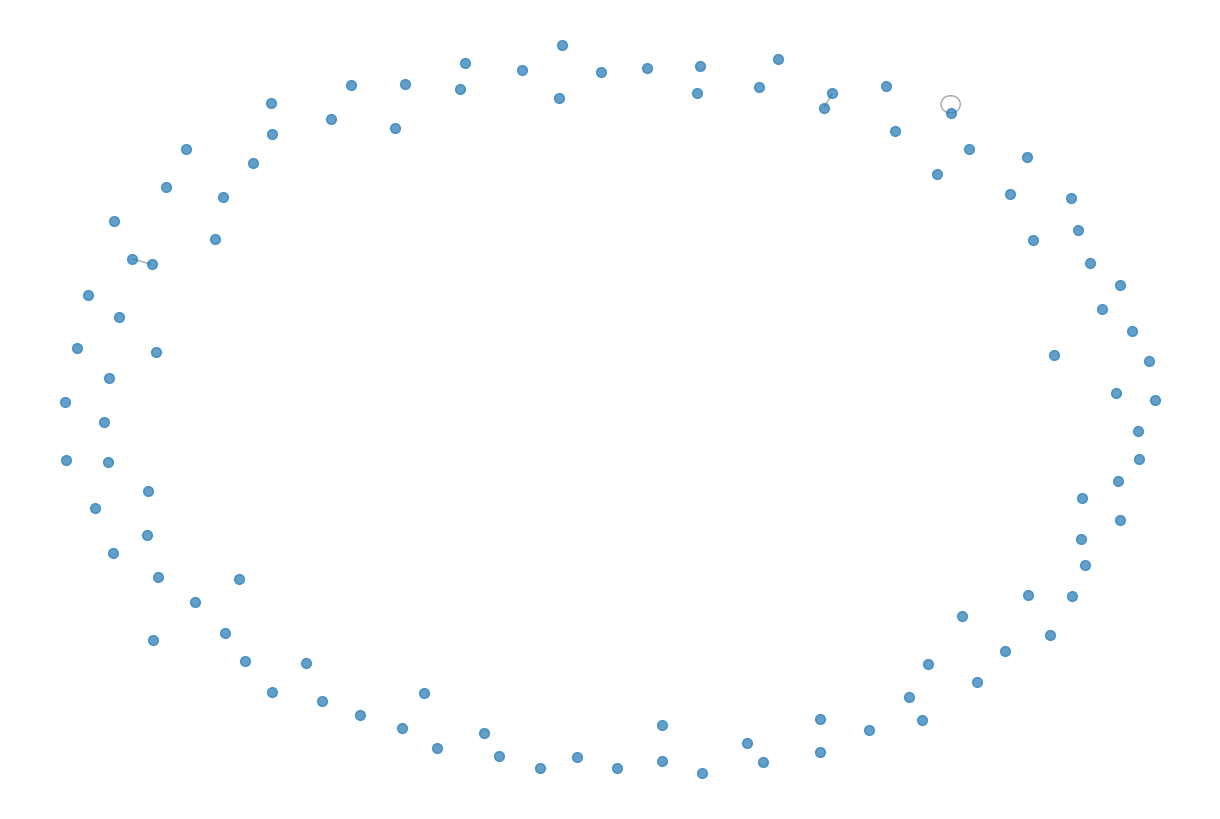

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
nx.draw(G, with_labels=False, node_size=50, edge_color='gray', alpha=0.7)

plt.show()